In [224]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\pohlm\.cache\kagglehub\datasets\meowmeowmeowmeowmeow\gtsrb-german-traffic-sign\versions\1


In [254]:
import pandas as pd
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torchvision.models import resnet50,resnet18
import torch.optim as optim

In [226]:
# read train dataset, filter for speed signs
train=pd.read_csv("Train.csv")
train.head(5)
train.ClassId.unique()

wanted_speeds=[1,2,3,4]
# class 0-> 20 speed , 1 -> 30 speed, 2 -> 50 , 3 -> 60, 4 -> 70

In [227]:
# 
train.head(5)


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [228]:
# drop not used values
train= train[train["ClassId"].isin(wanted_speeds)]
train.drop(columns=["Width", "Height", "Roi.X1", "Roi.Y1", "Roi.X2", "Roi.Y2"], inplace=True)



In [229]:
sum(train.duplicated())

0

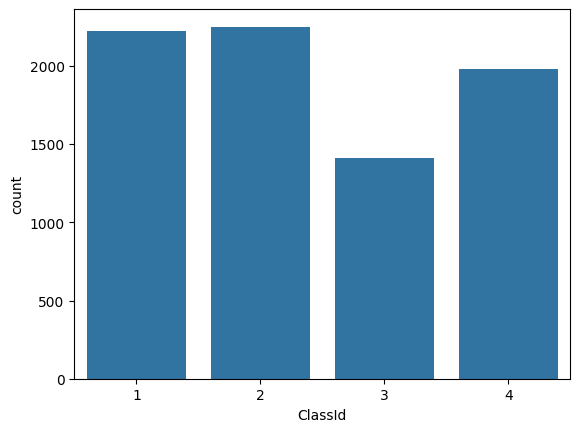

In [230]:
#see distribution of classes
sns.countplot(x = "ClassId", data = train)
plt.show()

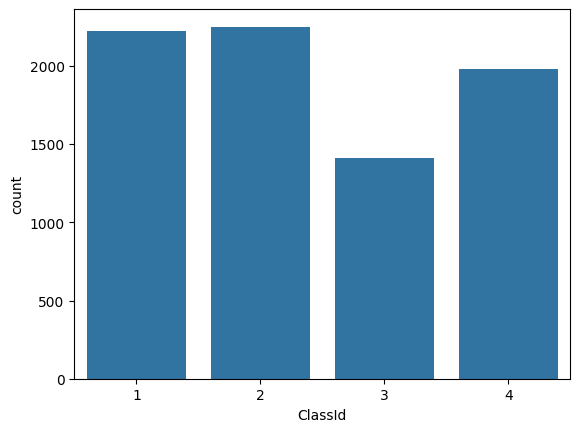

In [231]:
sns.countplot(x = "ClassId", data = train)
plt.show()

In [232]:
def preprocess(path):
    df= pd.read_csv(path+".csv")
    df= df[df["ClassId"].isin(wanted_speeds)]
    df.drop(columns=["Width", "Height", "Roi.X1", "Roi.Y1", "Roi.X2", "Roi.Y2"], inplace=True)
    return df.reset_index(drop=True)

In [233]:
test= preprocess("Test")
test.info()
test.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ClassId  2580 non-null   int64 
 1   Path     2580 non-null   object
dtypes: int64(1), object(1)
memory usage: 40.4+ KB


,ClassId,Path
0,1,Test/00001.png
1,4,Test/00014.png
2,4,Test/00020.png
3,3,Test/00023.png
4,1,Test/00024.png


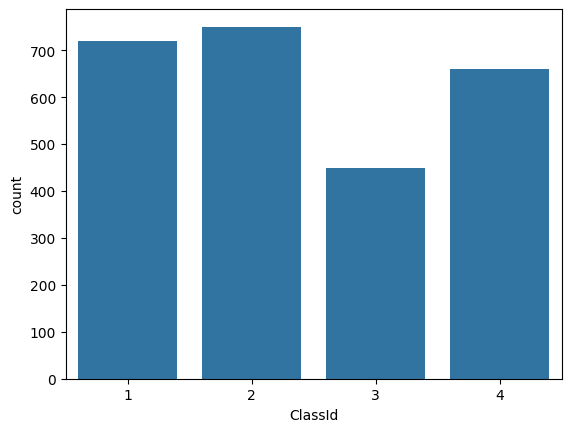

In [234]:
#see distribution of classes
sns.countplot(x = "ClassId", data = test)
plt.show()

In [235]:
n= len(test)//2
train_df,valid_df= train_test_split(train, test_size=0.15, random_state=42)
test_df= test

In [236]:
valid_df.shape

(1179, 2)

In [237]:
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor()  # scales pixel values to [0,1], shape (3, H, W)
])

class TrafficSignDataset():
    def __init__(self, df,  transform=None):
      
        self.data = df
        self.labels = torch.tensor(df["ClassId"].values, dtype=torch.long)
        self.images = self.transforms(self.data["Path"],transform)

    def __getitem__(self,idx):
        return self.images[idx], self.labels[idx]
    
    def __len__(self):
        # number of samples
        return len(self.data)
    def transforms(self,series,transform):
        path=series
        image_list=[]
        for p in path:

            image = Image.open(p).convert("RGB")
            #print(image)
            arr= transform(image)
            image_list.append(arr)
        image_tensor = torch.stack(image_list)
        print(image_tensor.shape)
        return image_tensor
       

In [238]:
train_dataset= TrafficSignDataset(train_df, transform=transform)
valid_dataset= TrafficSignDataset(valid_df, transform=transform)
test_dataset= TrafficSignDataset(test_df, transform=transform)

torch.Size([6681, 3, 32, 32])
torch.Size([1179, 3, 32, 32])
torch.Size([2580, 3, 32, 32])


In [239]:
train_loader= DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader= DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader= DataLoader(test_dataset, batch_size=32, shuffle=False)

In [240]:
for batch_images, batch_labels in train_loader:
    print(batch_images.shape)  # torch.Size([32, 3, 32, 32])
    print(batch_labels.shape)  # torch.Size([32])
    break

torch.Size([32, 3, 32, 32])
torch.Size([32])


In [266]:
# Task Create a deep learning Model with pytorch to classify the images

class TrafficSignNet(nn.Module):
    def __init__(self, num_classes=5):
        super(TrafficSignNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) # reduces from 32x32 to 16x16
        self.dropout = nn.Dropout(p=0.3)
        self.fc1= nn.Linear(64*16*16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self,x):
        #print(x.shape) #(32,3,32,32)
        x= self.conv1(x) #(32,32,32,32)
      
        x = F.relu(x)
        x= self.conv2(x)
        x = F.relu(x)
        x=self.pool(x)
        #print(x.shape)
        
        #x = F.max_pool2d(x, 2, 2)
        x = torch.flatten(x, 1)
        x= self.fc1(x)
        x= self.dropout(x)
        x = self.fc2(F.relu(x))
        #print(x.shape)
        return x

In [275]:
# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TrafficSignNet(num_classes=5).to(device)
#model = resnet18(weights=None).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) #weight decay for l2 regularization
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 50

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    scheduler.step()
    train_acc = correct/total
    avg_loss = train_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            #print(labels)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = correct/total
    avg_val_loss = val_loss / len(valid_loader)
    if epoch %10==0:
        print(f"Epoch [{epoch+1}/{num_epochs}] "
            f"Train Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f} "
            f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch [1/50] Train Loss: 0.8705, Train Acc: 0.6336 Val Loss: 0.4033, Val Acc: 0.8719
Epoch [11/50] Train Loss: 0.0062, Train Acc: 0.9988 Val Loss: 0.0204, Val Acc: 0.9932
Epoch [21/50] Train Loss: 0.0060, Train Acc: 0.9994 Val Loss: 0.0206, Val Acc: 0.9932
Epoch [31/50] Train Loss: 0.0067, Train Acc: 0.9994 Val Loss: 0.0201, Val Acc: 0.9932
Epoch [41/50] Train Loss: 0.0059, Train Acc: 0.9990 Val Loss: 0.0201, Val Acc: 0.9932


In [276]:
# on test data
all_preds=[]
all_labels=[]
test_loss, correct, total = 0, 0, 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        all_preds.append(predicted)
        all_labels.append(labels)

test_acc = correct / total
avg_test_loss =test_loss / len(test_loader)

print(f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.4f}")

Test Loss: 0.0990, Test Acc: 0.9709


In [277]:
label_array = np.concatenate(all_labels)

pred_array = np.concatenate(all_preds)


In [279]:
print("Label: ", label_array[1700:1720])
print("Predi: ", pred_array[1700:1720])

Label:  [4 4 1 2 1 2 4 3 1 4 4 2 4 1 2 4 1 1 2 3]
Predi:  [4 4 1 2 1 2 4 3 1 4 4 2 4 1 2 4 1 1 2 3]


In [278]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

print("Accuracy: ", accuracy(label_array, pred_array))

Accuracy:  0.9709302325581395


In [ ]:
# Accuracies, jedoch ohne Seed und Hyperparameteroptimierung

# Using adam, learning rate 0.001, epochen=10
# resnet18  test loss: 0.1223 model accuracy: 0.9578
# traffisgnnet test loss: 0.2067 model accuracy: 0.9512

# epochen= 50, lr scheduler
# trafficsignnet  Test Loss: 0.1281, Test Acc: 0.9620

# dropout 0.3 , epochen=50, lr scheduler
# trafficsignnet Test Loss: 0.0953, Test Acc: 0.9717

# dropout 0.5 , epochen=50, lr scheduler
# trafficsignnet Test Loss: 0.1097, Test Acc: 0.9671

# dropout 0.3 sgd optimizer lr 0.001
# trafficsignnet Test Loss: 1.3082, Test Acc: 0.4186

# dropout 0.3 sgd optimizer lr 0.01
# trafficsignnet Test Loss: 0.8728, Test Acc: 0.6740
